In [1]:
import numpy as np
import pandas as pd
import requests
# from bs4 import BeautifulSoup
import re
import gzip
import xml.etree.ElementTree as ET
from random import sample 
import math
import subprocess
import random
from collections import defaultdict
import glob, os, sys
import networkx as nx
from sklearn import svm
from sklearn.model_selection import train_test_split
import scipy
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)
malware_positions = glob.glob('/datasets/dsc180a-wi20-public/Malware/amd_data_smali/*/*/*')
benign_positions = glob.glob('../DSC180A/APKs/decompiled/*')[:200]
malware_positions = list(np.random.choice(malware_positions, 200, replace = False))
np.random.seed(1)

In [5]:
def get_class(file):
    """
    Return 1 if it is malware, 0 if benign
    """
    return int('dsc180a-wi20-public' in file)

def get_name(file):
    """
    Return name of the APP
    """
    return '-'.join(file.split('/')[-3:])

In [9]:
np.random.seed(0)
decompiled_apks = benign_positions + malware_positions

indices = np.random.choice(len(decompiled_apks), int(len(decompiled_apks)*0.8), replace = False)
train = [decompiled_apks[i] for i in indices]
# train = np.random.choice(decompiled_apks, int(len(decompiled_apks)*0.8), replace = False)
test = [apk for apk in decompiled_apks if apk not in train]

apk_names_train = [get_name(file) for file in train]
apk_classes_train = [get_class(file) for file in train]

apk_names_test = [get_name(file) for file in test]
apk_classes_test = [get_class(file) for file in test]

print(pd.Series(apk_classes_train).value_counts())
print(pd.Series(apk_classes_test).value_counts())

apk2idx_train = dict(zip(apk_names_train, range(len(apk_names_train))))
apk2idx_test = dict(zip(apk_names_test, range(len(apk_names_test))))

1    160
0    160
dtype: int64
1    40
0    40
dtype: int64


In [10]:
apk2node_train = dict(zip(apk_names_train, range(-len(apk_names_train), 0)))
node2apk_train = dict(zip(range(-len(apk_names_train), 0), apk_names_train))

'APKs-decompiled-medical-NMH_Guides'

In [1]:
with open('../DSC180A/APIs_400_apps.txt', 'r') as f:
    APIs = [a.strip() for a in f.readlines()]

In [ ]:
API2idx = dict(zip(APIs, range(len(APIs))))
idx2API = dict(zip(range(len(APIs)), APIs))

In [14]:
matrix_A_train = scipy.sparse.load_npz('../DSC180A/matrix_A_train_400_app.npz')
matrix_B_train = scipy.sparse.load_npz('../DSC180A/matrix_B_train_400_app.npz')
matrix_P_train = scipy.sparse.load_npz('../DSC180A/matrix_P_train_400_app.npz')

In [13]:
idx2apk_train = dict(zip(apk2idx_train.values(), apk2idx_train.keys()))

In [16]:
def APP_to_API_ABA(API, APP, apk2idx, node2apk, A, B, p, q):
    APP_idx = apk2idx[node2apk[APP]]
    ser = pd.Series(A[APP_idx].toarray()[0])
    A_neibors = ser[ser == 1].index
    if len(A_neibors) == 0:
        return None
    probs = [1 if B[n, API] else 1/q for n in A_neibors]
    probs[list(A_neibors).index(API)] = 1/p
    p_sum = sum(probs)
    probs = [p/p_sum for p in probs]
    API = np.random.choice(A_neibors, 1, p = probs).item()
    return API

def API_to_API_ABA(APP, API, apk2idx, node2apk, A, B, p, q):
    APP_idx = apk2idx[node2apk[APP]]
    ser = pd.Series(B[APP_idx].toarray()[0])
    B_neibors = ser[ser == 1].index
    if len(B_neibors) == 0:
        return None
    probs = [1 if A.T[n, APP_idx] else 1/q for n in B_neibors]
    p_sum = sum(probs)
    probs = [p/p_sum for p in probs]
    return np.random.choice(B_neibors, 1, p = probs).item()

def API_to_APP_ABA(API_pre, API, idx2apk, apk2node, A, p, q):
    ser = pd.Series(A.T[API].toarray()[0])
    A_neibors = ser[ser == 1].index
    if len(A_neibors) == 0:
        return None
    probs = [1 if A[n, API_pre] else 1/q for n in A_neibors]
    p_sum = sum(probs)
    probs = [p/p_sum for p in probs]
    APP_idx = np.random.choice(A_neibors, 1, p = probs).item()
    return apk2node[idx2apk[APP_idx]]

# APP1 ---> API1 ---> API2 ---> APP2
def generate_ABA_random_walks(APP_start, apk2idx, idx2apk, apk2node, node2apk, A, B, p, q, length):
    APP1 = apk2node[APP_start]
    APP_idx = apk2idx[APP_start]
    ser = pd.Series(A[APP_idx].toarray()[0])
    API1 = np.random.choice(ser[ser == 1].index, 1, replace = True).item()
    walk = [APP1, API1]
    while len(walk) < length:
        API2 = API_to_API_ABA(APP1, API1, apk2idx, node2apk, A, B, p, q)
        if not API2:
            return walk
        walk.append(API2)
        APP2 = API_to_APP_ABA(API1, API2, idx2apk, apk2node, A, p, q)
        if not APP2:
            return walk
        walk.append(APP2)
        API1 = APP_to_API_ABA(API2, APP2, apk2idx, node2apk, A, B, p, q)
        if not API1:
            return walk
        walk.append(API1)
        APP1 = APP2
    return walk

In [17]:
# APP1 ---> API1 ---> APP2
def APP_to_API_AA(API, APP, apk2idx, node2apk, A, p, q):
    APP_idx = apk2idx[node2apk[APP]]
    ser = pd.Series(A[APP_idx].toarray()[0])
    A_neibors = ser[ser == 1].index
    if len(A_neibors) == 0:
        return None
    probs = [1/p if n == API else 1 for n in A_neibors]
    p_sum = sum(probs)
    probs = [p/p_sum for p in probs]
    API = np.random.choice(A_neibors, 1, p = probs).item()
    return API

def API_to_APP_AA(APP, API, apk2idx, idx2apk, node2apk, apk2node, A, p, q):
    APP_idx = apk2idx[node2apk[APP]]
    ser = pd.Series(A.T[API].toarray()[0])
    A_neibors = ser[ser == 1].index
    if len(A_neibors) == 0:
        return None
    probs = [1/p if n == APP_idx else 1 for n in A_neibors]
    p_sum = sum(probs)
    probs = [p/p_sum for p in probs]
    APP_idx = np.random.choice(A_neibors, 1, p = probs).item()
    return apk2node[idx2apk[APP_idx]]

def generate_AA_random_walks(APP_start, apk2idx, idx2apk, apk2node, node2apk, A, p, q, length):
    APP1 = apk2node[APP_start]
    APP_idx = apk2idx[APP_start]
    ser = pd.Series(A[APP_idx].toarray()[0])
    API1 = np.random.choice(ser[ser == 1].index, 1, replace = True).item()
    walk = [APP1, API1]
    while len(walk) < length:
        APP2 = API_to_APP_AA(APP1, API1, apk2idx, idx2apk, node2apk, apk2node, A, p, q)
        if not APP2:
            return walk
        walk.append(APP2)
        API1 = APP_to_API_AA(API1, APP2, apk2idx, node2apk, A, p, q)
        if not API1:
            return walk
        walk.append(API1)
        APP1 = APP2
    return walk


In [14]:
from gensim.models import Word2Vec, KeyedVectors

In [13]:
walks = [list(map(str, walk)) for walk in walks]
model = Word2Vec(walks, size=128, window=10, min_count=0, sg=1, workers=8, iter=5)
model.wv.save_word2vec_format('AA_len500_k10_w2v.model')

In [10]:
# model = KeyedVectors.load_word2vec_format('AA_len500_k10_w2v.model')

In [98]:
model = KeyedVectors.load_word2vec_format('ABA_len100_k10_w2v.model')

In [99]:
apk2class_train = dict(zip(apk_names_train, apk_classes_train))

In [100]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [101]:
X = [model[str(apk2node_train[apk])] for apk in apk2idx_train if str(apk2node_train[apk]) in model.wv]
Y = [apk2class_train[apk] for apk in apk2idx_train if str(apk2node_train[apk]) in model.wv]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### AA_len500_k10

In [30]:
clf = svm.SVC()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.95703125
0.875


In [31]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.99609375
0.90625


In [32]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.90625


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.002s...
[t-SNE] Computed neighbors for 320 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 1.622571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.836487
[t-SNE] Error after 300 iterations: 0.965198


Text(0,0.5,'tsne-2d-two')

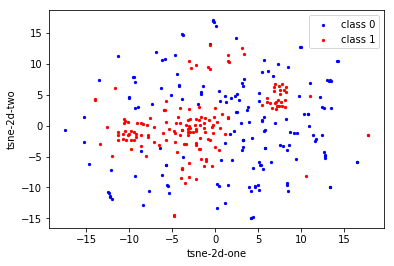

In [70]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
indices_neg1 = (np.array(Y) == 0).nonzero()[0]
indices_pos1 = (np.array(Y) == 1).nonzero()[0]
plt.scatter(tsne_results[:,0][indices_neg1], tsne_results[:,1][indices_neg1], s = 5, c='blue', label='class 0')
plt.scatter(tsne_results[:,0][indices_pos1], tsne_results[:,1][indices_pos1], s = 5, c='red', label='class 1')
plt.legend()
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")

### AA_len100_k10

In [30]:
clf = svm.SVC()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.875
0.828125


In [31]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.859375


In [32]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.953125


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.002s...
[t-SNE] Computed neighbors for 320 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.910057
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.607536
[t-SNE] Error after 300 iterations: 0.671652


Text(0.5,1,'Metapath AA, k = 10, n = 100')

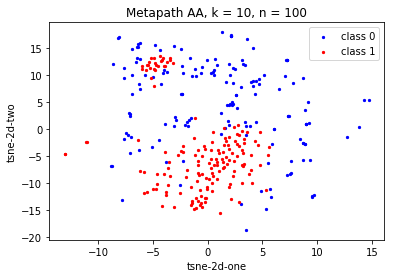

In [79]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
indices_neg1 = (np.array(Y) == 0).nonzero()[0]
indices_pos1 = (np.array(Y) == 1).nonzero()[0]
plt.scatter(tsne_results[:,0][indices_neg1], tsne_results[:,1][indices_neg1], s = 5, c='blue', label='class 0')
plt.scatter(tsne_results[:,0][indices_pos1], tsne_results[:,1][indices_pos1], s = 5, c='red', label='class 1')
plt.legend()
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.title('Metapath AA, k = 10, n = 100')

### AA_len20_k10

In [19]:
clf = svm.SVC()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8203125
0.75


In [20]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.8125


In [21]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.84375


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.002s...
[t-SNE] Computed neighbors for 320 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.298944
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.612518
[t-SNE] Error after 300 iterations: 0.383816


Text(0.5,1,'Metapath AA, k = 10, n = 20')

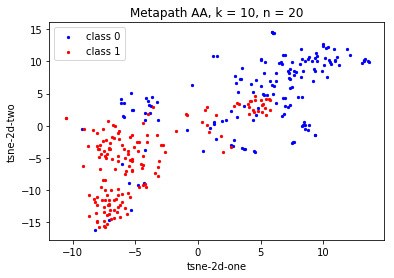

In [88]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
indices_neg1 = (np.array(Y) == 0).nonzero()[0]
indices_pos1 = (np.array(Y) == 1).nonzero()[0]
plt.scatter(tsne_results[:,0][indices_neg1], tsne_results[:,1][indices_neg1], s = 5, c='blue', label='class 0')
plt.scatter(tsne_results[:,0][indices_pos1], tsne_results[:,1][indices_pos1], s = 5, c='red', label='class 1')
plt.legend()
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.title('Metapath AA, k = 10, n = 20')

### ABA_len100_k10

In [23]:
clf = svm.SVC()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.61328125
0.640625


In [24]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.98828125
0.796875


In [25]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.75


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.002s...
[t-SNE] Computed neighbors for 320 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.142211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.387245
[t-SNE] Error after 300 iterations: 0.471529


Text(0.5,1,'Metapath ABA, k = 10, n = 100')

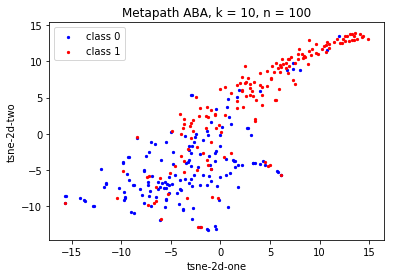

In [105]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
indices_neg1 = (np.array(Y) == 0).nonzero()[0]
indices_pos1 = (np.array(Y) == 1).nonzero()[0]
plt.scatter(tsne_results[:,0][indices_neg1], tsne_results[:,1][indices_neg1], s = 5, c='blue', label='class 0')
plt.scatter(tsne_results[:,0][indices_pos1], tsne_results[:,1][indices_pos1], s = 5, c='red', label='class 1')
plt.legend()
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.title('Metapath ABA, k = 10, n = 100')

In [44]:
(matrix_A_train.sum() + matrix_B_train.sum() / 2 ) / 320

49000.784375

 ### ABA_len20_k10

In [40]:
clf = svm.SVC()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.50390625
0.484375


In [41]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9921875
0.734375


In [42]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.671875


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.002s...
[t-SNE] Computed neighbors for 320 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.107571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.820599
[t-SNE] Error after 300 iterations: 0.227197


Text(0.5,1,'Metapath ABA, k = 10, n = 20')

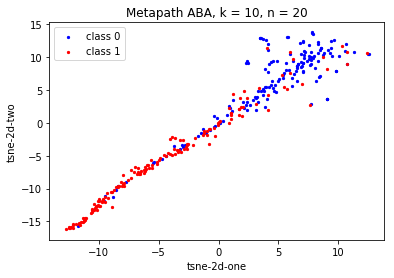

In [97]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
indices_neg1 = (np.array(Y) == 0).nonzero()[0]
indices_pos1 = (np.array(Y) == 1).nonzero()[0]
plt.scatter(tsne_results[:,0][indices_neg1], tsne_results[:,1][indices_neg1], s = 5, c='blue', label='class 0')
plt.scatter(tsne_results[:,0][indices_pos1], tsne_results[:,1][indices_pos1], s = 5, c='red', label='class 1')
plt.legend()
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.title('Metapath ABA, k = 10, n = 20')